##  Random forest with the injected data set 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

### Read in the data from Kelsey's file

In [2]:
ddir = "data/"
tcefile = "TESS_ML_20240412.txt"
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

In [3]:
# This is how well Jason's RF runs written as a confusion matrix
#Originally Jason/Kelsey Confusion Matrix
injected = tces['injrec'] == 1

for prob in np.arange(0.1,1,.2):
    jasonpassed = tces['trprob'] > prob  #This is arbitrary

    num00 = len(tces[~injected & ~jasonpassed])
    num01 = len(tces[~injected & jasonpassed])
    num10 = len(tces[injected & ~jasonpassed])
    num11 = len(tces[injected & jasonpassed])

    print("   ==>  For the Probability %f:" % prob)
    #print([num00,num01],"\n",[num10,num11])

    print(100*np.array([num00,num01])/(num00+num01),"\n",
          100*np.array([num10,num11])/(num10+num11))

   ==>  For the Probability 0.100000:
[98.07989365  1.92010635] 
 [  0. 100.]
   ==>  For the Probability 0.300000:
[99.52863308  0.47136692] 
 [ 3.127238 96.872762]
   ==>  For the Probability 0.500000:
[99.8745518  0.1254482] 
 [ 7.25113392 92.74886608]
   ==>  For the Probability 0.700000:
[9.99920425e+01 7.95753485e-03] 
 [12.84912867 87.15087133]
   ==>  For the Probability 0.900000:
[100.   0.] 
 [24.28383862 75.71616138]


Only some were used by Kelsey and Jason to vet, we will start with those for training, 
I'm not sure I entirely agree with choices.

In [4]:
metrics=[ #"period",
         "power","dur","depth","snr",
         #"deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3",
         "mindBIC","nloops",
         #"npoints","nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.3)

In [5]:
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.988498


Accuracy: 0.9891271322540041


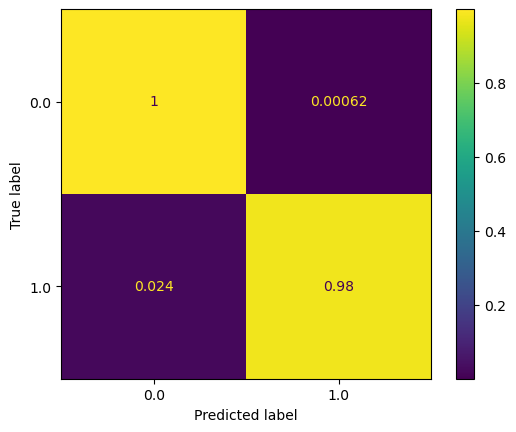

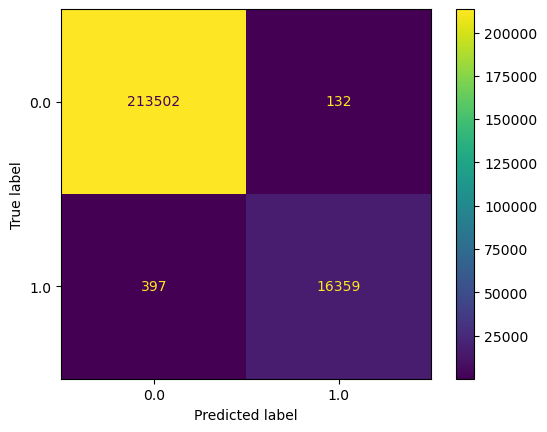

In [6]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## Compare and Improve

This appears to be only an 82% completeness and accuracy of 0.9801
Ways I tried to improve the training to get what I have above wihtout changing the metrics is the following:

- Max depth went from 4 --> None.  This greatly improved things to a 0.987 mean accuracy and only losing 4% of the  injected signals with true with less than 0.04% of false positives miscalssified.
- I tried increasing the number is split samples to 4, but seemed to make things a bit worse.
- I looked at n_estimators from 10 --> 20, this gave me significant improvement.No only missing 2.9% of the true positives and now 0.07% of the false positives misclassified. (39 s runtime)
- I doubled the number of classifiers again to 40. This got me to 2.4% and 0.073%.  so let's stop there with that one.

Let's now switch out the algorithm a bit.
DecisionTree Classifier and ExtraTreesClassifier might work better. So I try them below. There is not significant improvement at least shown in any of these ways of evaluating the forrest.

Even if only consider the precision an drecall of the test sets, I do best form the Random forest.





Cross Validation Score mean: 0.981385
Accuracy: 0.9828117539823777
Precision: 0.877317, Recall: 0.888293


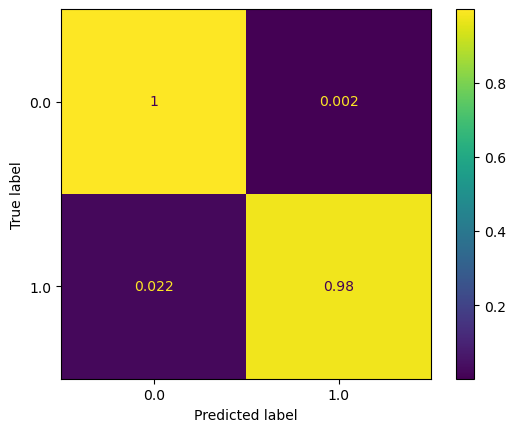

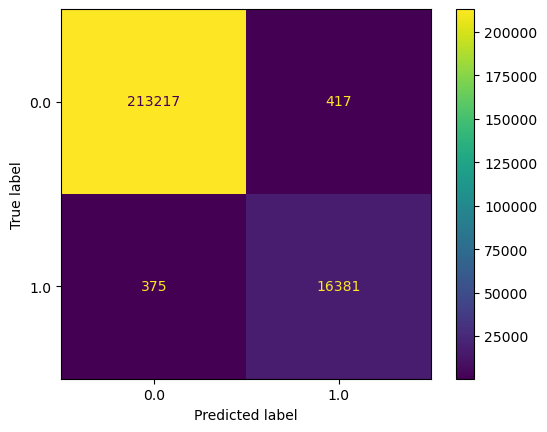

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

rf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

Cross Validation Score mean: 0.987413
Accuracy: 0.9881939320282999
Precision: 0.957398, Recall: 0.876973


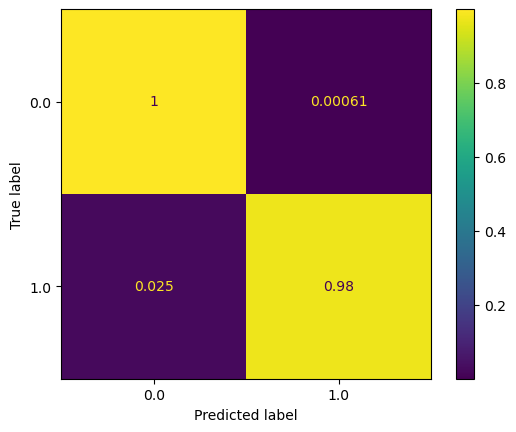

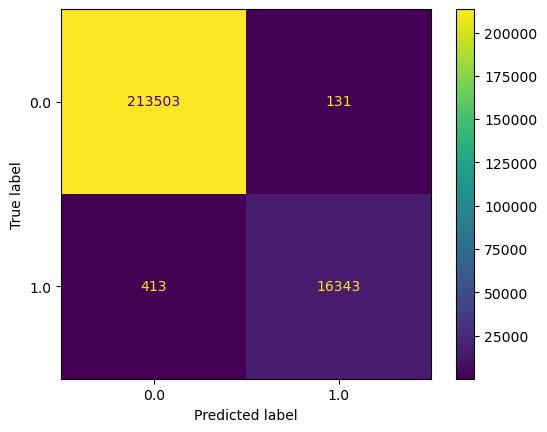

In [13]:
rf = ExtraTreesClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

Cross Validation Score mean: 0.988498
Accuracy: 0.9891271322540041
Precision: 0.957692, Recall: 0.890080


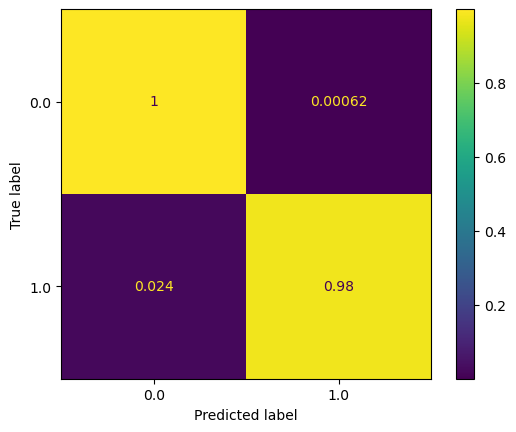

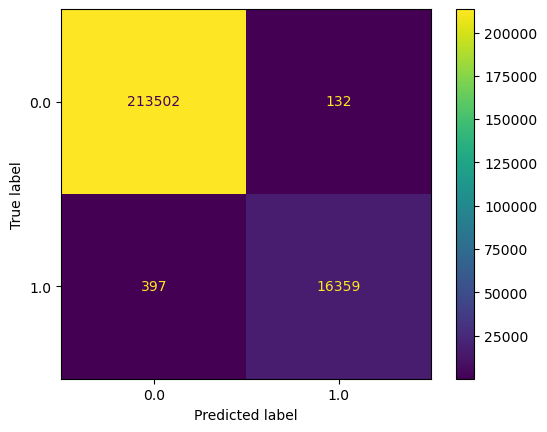

In [14]:

rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## ROC and probability.
Receiver operator curve would be good to see as well.
Then we could also get an idea of confidence

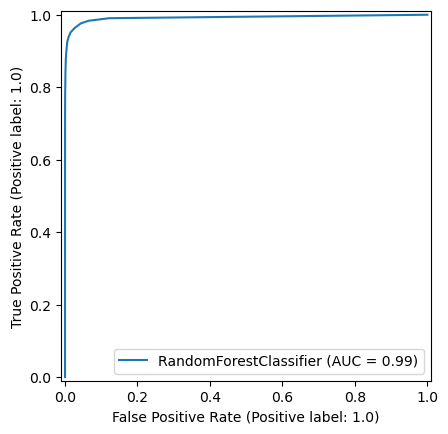

In [11]:
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
from sklearn.metrics import roc_auc_score


In [17]:
#Get probabilities
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_prob[:,1])

0.9922923672718855

In [18]:
#Record the results in the TCEs for the entire data set.
y_all = rf.predict(X)
y_prob = rf.predict_proba(X)

tces['newRF'] = y_all
tces['newRFprob'] = y_prob[:,1]  #Probability it is class "transit"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

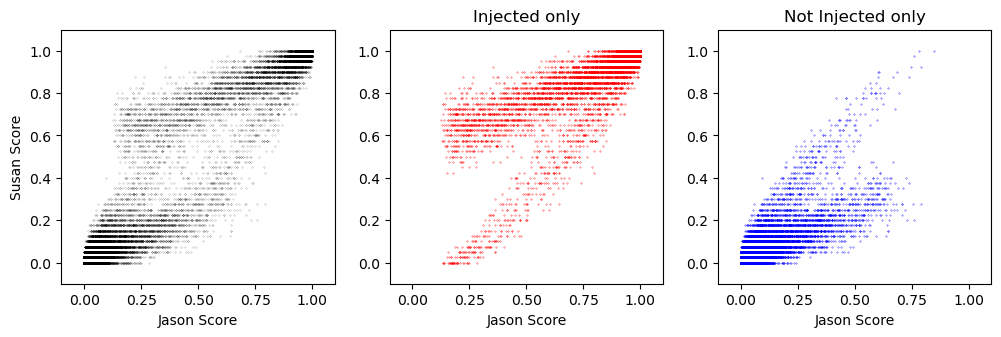

In [39]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Not Injected only')
plt.tight_layout

In [38]:
## What sort of features are most important
isort = np.argsort(rf.feature_importances_)
for i,m in enumerate(metrics):
    print(m, 100*rf.feature_importances_[i])

power 1.4724988312888858
dur 2.9037777140859413
depth 2.9024115668833987
snr 12.45524178746967
chisq 5.825509017949193
bicft 8.359017060378104
bicplus 2.643843902209494
bicminus 3.2747811741512782
snrshape 13.713500452406263
noise 1.1490192826883148
depth_shape2 15.124375471328449
depth_shape3 25.120646849883503
mindBIC 2.955686950367435
nloops 2.0996899389100845
